# ASSIGNMENT 1 - Speech recognition

what I will do:
* load all the audio files
* extract from the filenames the digit labels (to use as GT)
* compute all the MFCCs (to use as audio feature)
* split the data into train and test sets
* use a Random Forest algorithm
* test the model
* compute a confusion matrix

## PER QUANTO RIGUARDA IL NUMERO DI MFCC **************************

a parte il cambiare il valore alla variabile n_mfcc che creo nella cella [3], bisogna modificare la cella [11] in questo punto:

(qua l'esempio è con 20 MFCCs)


 X = df_same_digit.iloc[:, 0:20]          
 y = df_same_digit.iloc[:, 20]            

In [1]:
import numpy as np
import pandas as pd
import librosa.display
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import tqdm

## Create the dictionary

I create a dictionary that I will use both to create the Pandas data frame (which I will use only to split train and test sets) and to store the MFCCs values before converting them to matrices.

In [18]:
data = {'mfcc':[], 'labels':[], 'speaker':[], 'train_set':[], 'train_target_set':[], 'test_set':[], 'test_target_set':[]}

## Compute the data


In [3]:
#some preliminary steps:

data_path = "recordings"  
n_mfcc = 20 
elements = os.listdir(data_path)  

#number_of_elements = len(elements)

### Some notes:

* each audio file generates different numbers of samples --> to make our data homogeneous we'll take the mean value of all the MFCCs we're collecting from all samples. This way we get only n_mfcc coefficients for each audio file --> n_mfcc rows vector for each audio file


* the MFCCs get stored in the dictionary key "mfcc" which is a list of 3000 vectors with n_mfcc rows


* I will use tqdm to see how long it takes for the for loop to finish (little less than 1 min)


* n_fft : I chose 2048 but it may change. Don't know if it's good.

In [4]:
#extract the digit labels from each wav file
for i, filename in enumerate(tqdm.tqdm(elements)):
    file_name_components = filename.split("_")
    digit_label = file_name_components[0]
    data["labels"].append(digit_label)
    #data["speaker"].append(speaker_name)  #this is not really a necessary data to collect
        
    #load the audio files
    audio, sr = librosa.load(os.path.join(data_path, filename))
        
    #compute the MFCCs for each audio file
    mfcc = librosa.feature.mfcc(audio, n_fft = 2048, hop_length = 512, n_mfcc = n_mfcc)
    feature_vector =np.mean(mfcc, axis = 1)
    
    #features_matrix[i,:] = feature_vector
    data["mfcc"].append(feature_vector)
    

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:56<00:00, 53.05it/s]


Next there are some checks that I did to see if everything was working properly...

In [5]:
len(data["mfcc"])   #should be 3000

3000

In [7]:
data["mfcc"][0].size    #should be equal to n_mfcc chosen

20

### Listen to the last audio loaded

In [8]:
ipd.Audio(audio, rate=sr)

### Visualize the last MFCCs computed (no mean value yet)

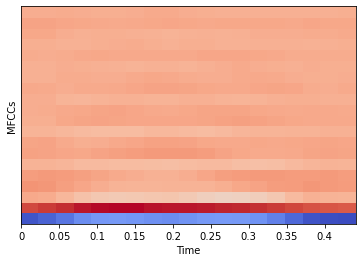

In [9]:
librosa.display.specshow(mfcc,
                        x_axis = 'time',
                        sr=sr)

plt.xlabel('Time')
plt.ylabel('MFCCs')
plt.show() 

## Creating the Pandas Data Frame

I create this data frame for the sole purpose of splitting the data into train and test sets in a non-biased way FOR EACH class of digits. The train_test_split method from scikit learn will provide the randomness and it doesn't require data frames per se... BUT I need the data frame to apply the method on each different class of digits!

The last column has the target values.

In [10]:
df = pd.DataFrame(data["mfcc"])   
df['digit_label'] = data["labels"]
#df['speaker_name']=data["speaker"]  #not needed

# call df below if you want to visualize the data frame
df.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,digit_label
0,-315.476044,165.164124,-86.001862,49.906296,49.994198,-56.597046,-12.610107,-16.555233,-53.435623,-10.625828,...,-43.135574,3.244191,-5.556155,-28.044035,-1.858222,-4.968933,-12.910381,-1.180161,-11.717236,0
1,-377.584045,166.679581,-57.934063,23.156776,26.331282,-46.027672,-13.796629,-25.808290,-52.275322,-8.853588,...,-40.183712,-2.011989,-6.429522,-25.596296,-6.817262,-10.267634,-16.110767,-5.768830,-14.243267,0
2,-422.332245,128.056046,-54.102139,18.466105,26.394096,-33.143406,-13.631346,-19.045700,-32.075581,-5.010424,...,-34.712395,-1.574481,-11.154457,-23.685780,-0.622794,-4.097484,-10.547661,-1.414897,-11.413449,0
3,-388.007782,166.976837,-79.601295,25.804943,32.820518,-50.730679,-10.477678,-17.126139,-45.165600,-4.768176,...,-41.363216,-0.266976,-11.913630,-26.663418,1.560118,-5.737462,-13.478531,-2.150522,-15.060717,0
4,-387.697266,170.395508,-77.295441,23.309792,36.560810,-46.060402,-12.925955,-17.795551,-43.572300,-4.862560,...,-41.409332,-1.230233,-10.544313,-27.991896,-1.892762,-7.834771,-16.043837,-3.429716,-16.882401,0


## Split test and training sets

NOTE : This is meant to work with whatever group of digits (may be 0-3, 4-7, 0-9...).

* In the first part of the for loop I pick iteratively only one class of digits (first the 0s, then the 1s, the 2s...) and divide the data frame into data and targets.

* In the second part of the loop I actually split the data and the targets into train and test so that the test data will be around 20% of the total (see the test_size argument)

* In the third part I return to numpy arrays, so that I can merge together the train and test data I got from each different digit class (because the classifier works with 2d matrices).

This is very fast for loop.

In [11]:
digits=np.unique(data["labels"])  #understand what digits we are working with

for i in tqdm.tqdm(digits):
    df_same_digit = df[df.digit_label == i]
    X = df_same_digit.iloc[:, 0:20]          #taking the first 20 columns of the data frame (which are the MFCCs)
    y = df_same_digit.iloc[:, 20]            #taking the last column of the data frame (which is the target)
    
    #splitting 
    X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=0, test_size=0.2)
    
    
    X_train_np = (X_train).to_numpy()    #using Pandas' function to transform data frame into numpy array
    data["train_set"].append(X_train_np)
    TRAIN = np.concatenate(data["train_set"], axis=0)
    
    X_test_np = (X_test).to_numpy()   
    data["test_set"].append(X_test_np)
    TEST = np.concatenate(data["test_set"], axis=0)
    
    y_train_np = (y_train).to_numpy()    
    data["train_target_set"].append(y_train_np)
    TRAIN_TARGET = np.concatenate(data["train_target_set"], axis=0)   
    
    y_test_np = (y_test).to_numpy()    
    data["test_target_set"].append(y_test_np)
    TEST_TARGET = np.concatenate(data["test_target_set"], axis=0)

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 250.67it/s]


Here I run some codes to check how my data now looks.

First I take a look at the results I get immediately after the splitting. You can notice that the splitting produced pandas data frames in which is very easy to see how the splitting algorithm worked.

In [ ]:
#print(X_train)  #this is just for the digit "2"
#print(type(X_train))

Once you transform those back to numpy arrays you can get this:

In [ ]:
# print(X_train_np)          #notice that it's the same as above, obviously
# print((X_train).shape)
# print(type(X_train_np))

It may be useful to check also the concatenated matrices:

In [ ]:
#print(TRAIN.shape)
# print(type(TRAIN))
# print(TRAIN)

In [ ]:
#let's take a look at the target
#TRAIN_TARGET
#print(TRAIN_TARGET)



Let's recap and see if everything is ready to be used with the classifier:


In [14]:
print(TRAIN.shape)
print(TRAIN_TARGET.shape)
print(TEST.shape)
print(TEST_TARGET.shape)


(2400, 20)
(2400,)
(600, 20)
(600,)


## Random Forest Classifier

In [15]:
#create the random forest classifier
clf = RandomForestClassifier(n_jobs=2, random_state=0)

#training
clf.fit(TRAIN, TRAIN_TARGET)

RandomForestClassifier(n_jobs=2, random_state=0)

In [16]:
a = clf.predict(TEST)

# call the following to actually see the prediction results:
#print(a)

To get the confusion matrix I use Pandas function "crosstab".

In [17]:
pd.crosstab(TEST_TARGET, a,  rownames=['Actual digits'], colnames=['Predicted digits'])

Predicted digits,0,1,2,3,4,5,6,7,8,9
Actual digits,,,,,,,,,,
0,57,1,0,1,1,0,0,0,0,0
1,1,57,0,0,0,0,0,1,0,1
2,1,0,57,2,0,0,0,0,0,0
3,0,1,1,57,0,0,0,0,1,0
4,0,1,0,0,59,0,0,0,0,0
5,0,0,0,0,0,58,0,1,0,1
6,0,0,0,1,0,0,58,0,1,0
7,1,1,0,1,0,1,1,55,0,0
8,1,0,0,0,0,0,0,0,59,0
